In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
records = []
records_chunks = []

phone_name = 'nexus5'
directory = f'nexus5runs'

for file_name in os.listdir(directory):
#     print(file_name)
    stuff = re.search(r'log_video_(\d+)fps(\d+)p_([\d_]+)([nmc]{1})', file_name)
    if stuff == None:
        continue
    fps, res, mem_state, run_number = int(stuff.group(1)), int(stuff.group(2)), stuff.group(4), float(stuff.group(3).replace('_', '.'))
    
    with open(directory + '/' + file_name) as f:
        lines = list(f.readlines())
#         print(file_name, fps, run_number, len(lines))
        last_record = lines[-1].split('\t')
        if len(last_record) != 11:
            print(f'error parsing {directory}/{file_name}')
        else:
            crashed = int(len(lines) != 45)
            remained_in_moderate = 0
            went_into_critical = 1 if mem_state == 'm' and crashed == 0 else 0
            remained_in_critical = 1 if mem_state == 'c' and crashed == 0 else 0
            situation = 'Remained in Normal'
            if crashed:
                situation = 'Crashed'
            elif went_into_critical:
                situation = 'Went into Critical'
            elif remained_in_critical:
                situation = 'Remained in Critical'
            records.append([phone_name, float(last_record[0])*1000, mem_state, res, fps, int(run_number), int(last_record[-3]), int(last_record[-2]), crashed, len(lines), float(last_record[-4]), float(last_record[-9]), remained_in_moderate, went_into_critical, remained_in_critical, situation])
            
            count = 0
            for line in [line.split('\t') for line in lines]:
#                 print(line)
                if len(line) > 1:
                    records_chunks.append([phone_name, float(line[0])*1000, mem_state, res, fps, int(run_number), count,
                                    int(line[-3]),
                                   int(line[-2]),
                                   crashed,
                                   len(lines),
                                    float(line[-4]), float(line[-9]), float(line[-1]),
                                    remained_in_moderate, went_into_critical, remained_in_critical, situation])
                    count += 1
            
raw_df = pd.DataFrame(records, columns=['Phone', 'timestamp','Mem. State', 'Resolution', 'FPS', 'Run No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])
raw_df_chunks = pd.DataFrame(records_chunks, columns=['Phone', 'timestamp', 'Mem. State', 'Resolution', 'FPS', 'Run No.', 'Chunk No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Rendered FPS', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])

In [3]:
# normal df
df = raw_df.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.'])
df['%age Frames Dropped'] = (df['Dropped Frames']/df['Total Frames'])*100

# df chunks
df_chunks = raw_df_chunks.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.', 'Chunk No.'])
df_chunks['%age Frames Dropped'] = (df_chunks['Dropped Frames']/df_chunks['Total Frames'])*100

In [4]:
def change_mem_state_label(label):
    if label == 'n':
        return 'normal'
    elif label == 'm':
        return 'moderate'
    elif label == 'c':
        return 'critical'
    else:
        return label

In [5]:
df['Mem. State'] = df['Mem. State'].apply(change_mem_state_label)
df_chunks['Mem. State'] = df_chunks['Mem. State'].apply(change_mem_state_label)

In [11]:
# df.groupby(['FPS', 'Resolution', 'Mem. State']).count()

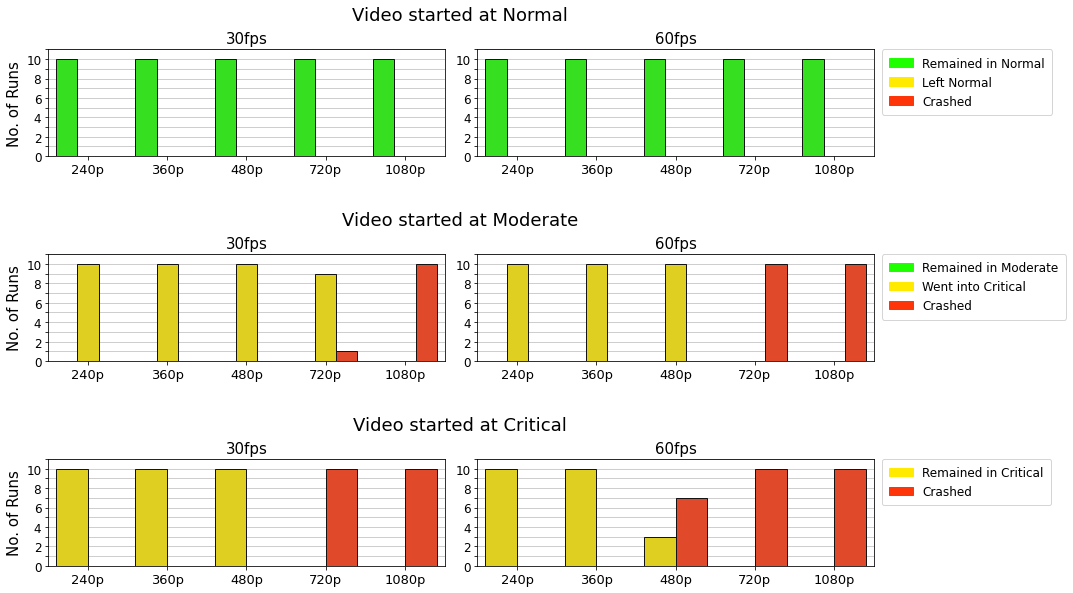

In [12]:
# sns.set(style="ticks")

def get_normal_axis(ax, fps):
    
    data = df.loc[df['FPS'] == fps].loc[df['Mem. State'] == 'normal']

    # print(data)

    sns.barplot(ax=ax, data=data, x='Resolution', y='Run No.', hue='Situation', edgecolor='#141414', linewidth=1,estimator=len, hue_order=['Remained in Normal', 'Left Normal', 'Crashed'], palette={'Remained in Normal': '#1eff00', 'Left Normal': '#ffea00', 'Crashed': '#ff350a'})

    ax.set_title(f'{fps}fps', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    if fps==30:
        ax.set_ylabel('No. of Runs', fontsize=15)
    else:
        ax.set_ylabel('', fontsize=15)

    p1 = mpatches.Patch(color='#1eff00', label='Remained in Normal')
    p2 = mpatches.Patch(color='#ffea00', label='Left Normal')
    p3 = mpatches.Patch(color='#ff350a', label='Crashed')

    ax.legend(handles=[p1,p2,p3], bbox_to_anchor=(1.02, 1), loc=2, fontsize=12, borderaxespad=0., borderpad=0.6)

    ax.set_yticks(range(0,12))
    ticks = []
    for i in range(0, 12, 2):
        ticks.append(i)
        ticks.append('')
    ax.set_yticklabels(ticks, fontsize=12)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=13)

    if fps == 30:
        ax.get_legend().remove()

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    return ax

def get_moderate_axis(ax, fps):

    data = df.loc[df['FPS'] == fps].loc[df['Mem. State'] == 'moderate']

    sns.barplot(ax=ax, data=data, x='Resolution', y='Run No.', hue='Situation',edgecolor='#141414', linewidth=1, estimator=len, hue_order=['Remained in Moderate', 'Went into Critical', 'Crashed'], palette={'Remained in Moderate': '#1eff00', 'Went into Critical': '#ffea00', 'Crashed': '#ff350a'})

    ax.set_title(f'{fps}fps', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    if fps==30:
        ax.set_ylabel('No. of Runs', fontsize=15)
    else:
        ax.set_ylabel('', fontsize=15)

    p1 = mpatches.Patch(color='#1eff00', label='Remained in Moderate')
    p2 = mpatches.Patch(color='#ffea00', label='Went into Critical')
    p3 = mpatches.Patch(color='#ff350a', label='Crashed')

    ax.legend(handles=[p1,p2,p3], bbox_to_anchor=(1.02, 1), loc=2, fontsize=12, borderaxespad=0., borderpad=0.6)

    ax.set_yticks(range(0,12))
    ticks = []
    for i in range(0, 12, 2):
        ticks.append(i)
        ticks.append('')
    ax.set_yticklabels(ticks, fontsize=12)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=13)

    if fps == 30:
        ax.get_legend().remove()

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    return ax

def get_critical_axis(ax, fps):

    data = df.loc[df['FPS'] == fps].loc[df['Mem. State'] == 'critical']

    sns.barplot(ax=ax, data=data, x='Resolution', y='Run No.', hue='Situation', edgecolor='#141414', linewidth=1,estimator=len, hue_order=['Remained in Critical', 'Crashed'], palette={'Remained in Critical': '#ffea00', 'Crashed': '#ff350a'})

    ax.set_title(f'{fps}fps', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    if fps==30:
        ax.set_ylabel('No. of Runs', fontsize=15)
    else:
        ax.set_ylabel('', fontsize=15)

    p2 = mpatches.Patch(color='#ffea00', label='Remained in Critical')
    p3 = mpatches.Patch(color='#ff350a', label='Crashed')

    ax.legend(handles=[p2,p3], bbox_to_anchor=(1.02, 1), loc=2, fontsize=12, borderaxespad=0., borderpad=0.6)

    ax.set_yticks(range(0,12))
    ticks = []
    for i in range(0, 12, 2):
        ticks.append(i)
        ticks.append('')
    ax.set_yticklabels(ticks, fontsize=12)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=13)

    if fps == 30:
        ax.get_legend().remove()
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    return ax

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(15,8))

get_normal_axis(ax11, 30)
get_normal_axis(ax12, 60)

get_moderate_axis(ax21, 30)
get_moderate_axis(ax22, 60)

get_critical_axis(ax31, 30)
get_critical_axis(ax32, 60)

plt.tight_layout(h_pad=6)

ax12.text(-0.725, 14, 'Video started at Normal', fontsize=18, horizontalalignment='center')
ax22.text(-0.725, 14, 'Video started at Moderate', fontsize=18, horizontalalignment='center')
ax32.text(-0.725, 14, 'Video started at Critical', fontsize=18, horizontalalignment='center')

plt.savefig(f"./nexus5_1.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.8)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')

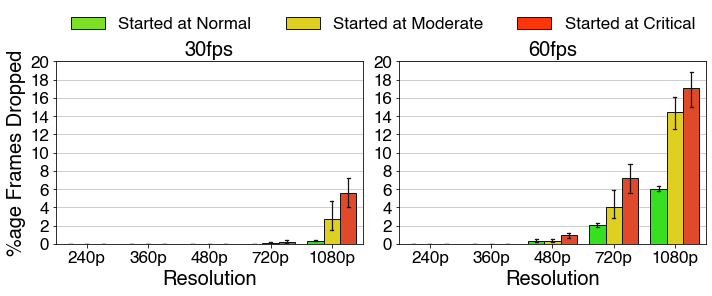

In [60]:
FONT_SM = 17
FONT_LR = 20

def plot_frames_dropped(ax, fps):
    
    sns.barplot(ax=ax, data=df.loc[df['FPS'] == fps].loc[df['Run No.'] >= 0], x='Resolution', y='%age Frames Dropped',
                hue='Mem. State',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                

    ax.set_title(f'{fps}fps', fontsize=FONT_LR)
    ax.set_xlabel('Resolution', fontsize=FONT_LR)
    if fps==60:
        ax.set_ylabel('', fontsize=FONT_LR)
    else:
        ax.set_ylabel('%age Frames Dropped', fontsize=FONT_LR)

    # if fps == 30:
    #     pass
    #     ax.set_yticks(np.arange(0,9,1))
    #     ax.set_yticklabels(np.arange(0,9,1), rotation=0, fontsize=FONT_SM)
    # else:
    ax.set_yticks(range(0,21,2))
    ax.set_yticklabels(range(0,21,2), rotation=0, fontsize=FONT_SM)
    # ax.set_yticklabels([0, '', 4, '', 8, '', 12, '', 16, '', 20], rotation=0, fontsize=FONT_SM)
    

    # ax.set_xticks(range(0,5))

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=FONT_SM)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.75))

plot_frames_dropped(ax1, 30)
plot_frames_dropped(ax2, 60)

plt.tight_layout()

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

ax1.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.015, 1.3), loc=2, fontsize=FONT_SM, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

# plt.title('Frames Drop')

# plt.text(-0.595, 28, 'Frames Dropped when video eventually crashed', fontsize=20, horizontalalignment='center')

# ax1.text(2, 20, 'Frames Dropped', fontsize=25, horizontalalignment='center')

plt.savefig(f"./nexus5_frames.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')

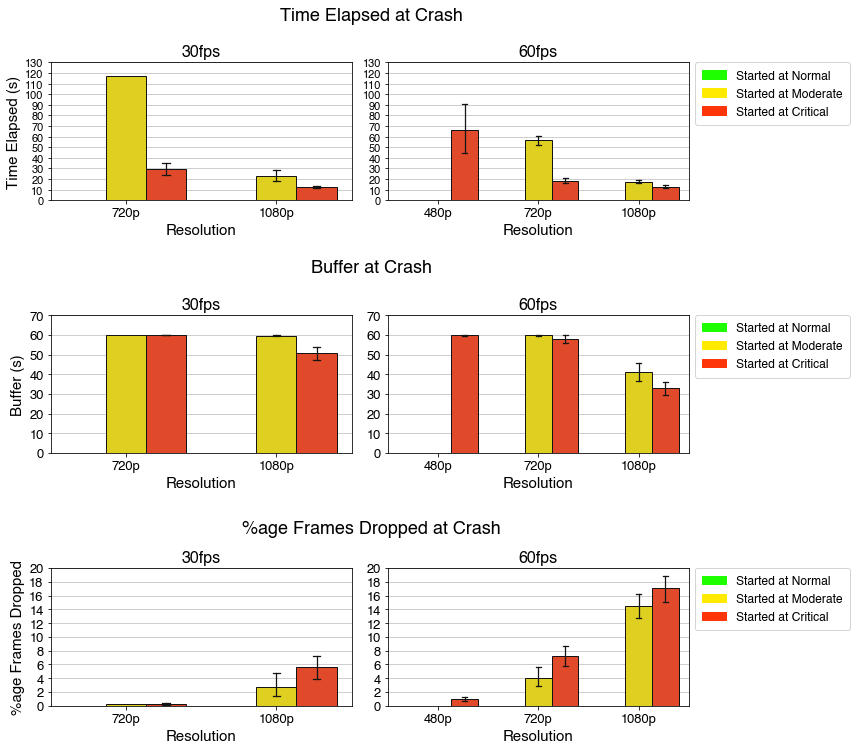

In [8]:
def plot_crashed(ax, fps, y_name, y_ticks, yticks_fontsize=13):
    
    sns.barplot(ax=ax, data=df.loc[df['FPS'] == fps].loc[df['Crashed'] == 1],
                x='Resolution', y=y_name, hue='Mem. State',
                hue_order=['normal', 'moderate', 'critical'],
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')

    ax.set_title(f'{fps}fps', fontsize=16)
    ax.set_xlabel('Resolution', fontsize=15)
    if fps==30:
        ax.set_ylabel(y_name, fontsize=15)
    else:
        ax.set_ylabel('', fontsize=15)

    p1 = mpatches.Patch(color='#1eff00', label='Started at Normal')
    p2 = mpatches.Patch(color='#ffea00', label='Started at Moderate')
    p3 = mpatches.Patch(color='#ff350a', label='Started at Critical')

    ax.legend(handles=[p1,p2,p3], bbox_to_anchor=(1.02, 1), loc=2, fontsize=12, borderaxespad=0., borderpad=0.6)

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, rotation=0, fontsize=yticks_fontsize)

    if fps == 30:
        ax.set_xticklabels(['720p', '1080p'], rotation=0, fontsize=13)
    else:
        ax.set_xticklabels(['480p', '720p', '1080p'], rotation=0, fontsize=13)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')
    
    if fps == 30:
        ax.get_legend().remove()


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,10))

plot_crashed(ax1, 30, 'Time Elapsed (s)', range(0, 130+1, 10), yticks_fontsize=11)
plot_crashed(ax2, 60, 'Time Elapsed (s)', range(0, 130+1, 10), yticks_fontsize=11)
plot_crashed(ax3, 30, 'Buffer (s)', range(0, 70+1, 10))
plot_crashed(ax4, 60, 'Buffer (s)', range(0, 70+1, 10))
plot_crashed(ax5, 30, '%age Frames Dropped', range(0, 20+1, 2))
plot_crashed(ax6, 60, '%age Frames Dropped', range(0, 20+1, 2))

plt.tight_layout(h_pad=6)

# ax2.text(-0.725, 4.05, 'Time Elapsed at Crash', fontsize=18, horizontalalignment='center')
# ax4.text(-0.725, 14, 'Buffer at Crash', fontsize=18, horizontalalignment='center')
# ax6.text(-0.725, 14, '%age Frames Dropped at Crash', fontsize=18, horizontalalignment='center')

ax2.text(-0.66, 170, 'Time Elapsed at Crash', fontsize=18, horizontalalignment='center')
ax4.text(-0.66, 92, 'Buffer at Crash', fontsize=18, horizontalalignment='center')
ax6.text(-0.66, 25, '%age Frames Dropped at Crash', fontsize=18, horizontalalignment='center')


plt.savefig(f"./nexus5_3.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.5)

# ax = sns.barplot(data=df_60fps, x='Resolution', y='%age Frames Dropped', hue='Mem. State')